# 모델 학습 및 평가 (Model Training & Evaluation)

## 목표
- 가맹점 폐업 예측 모델 학습
- XGBoost, LightGBM 모델 비교
- Hyperparameter tuning
- Feature importance 분석
- SHAP value 분석
- 모델 평가 및 해석

## 작업 내역
1. 데이터 로드 및 전처리
2. Train/Validation/Test Split (시계열 고려)
3. 불균형 데이터 처리
4. Baseline 모델 (XGBoost, LightGBM)
5. Cross-validation
6. Hyperparameter Tuning
7. Feature Importance 분석
8. SHAP Value 분석
9. Ensemble 모델
10. 최종 평가 및 모델 저장

## 1. 환경 설정

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc,
    precision_score, recall_score, f1_score, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# 모델
import xgboost as xgb
import lightgbm as lgb

# SHAP
import shap

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# 커스텀 모듈 임포트
import sys
sys.path.append('..')

from pipeline.models import (
    XGBoostModel,
    LightGBMModel,
    EnsembleModel
)
from pipeline.evaluation import (
    ModelEvaluator,
    calculate_metrics,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix
)

print("Custom modules loaded successfully")

Custom modules loaded successfully


## 2. 데이터 로드

In [3]:
# Feature engineering 완료된 데이터 로드
data_path = Path('../data/processed/featured_data.csv')

if not data_path.exists():
    print("Warning: featured_data.csv not found. Using preprocessed_data.csv instead.")
    data_path = Path('../data/processed/preprocessed_data.csv')

df = pd.read_csv(data_path)

print(f"Loaded data shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print(f"Rows: {len(df):,}")
print(f"Unique merchants: {df['ENCODED_MCT'].nunique():,}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

Loaded data shape: (86590, 182)

Columns: 182
Rows: 86,590
Unique merchants: 4,185
Date range: 202301 ~ 202412



Target variable: is_closed
is_closed
0    84256
1     2334
Name: count, dtype: int64

Positive rate: 2.70%


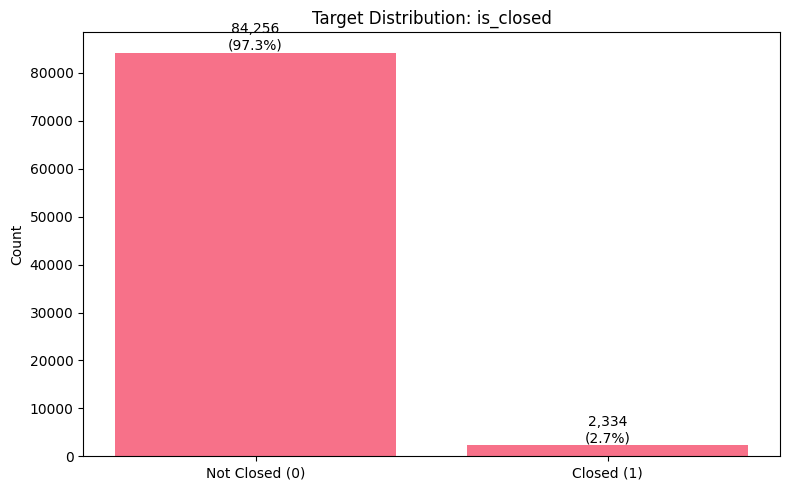

In [4]:
# 타겟 변수 분포 확인
target_col = 'is_closed'

if target_col in df.columns:
    print(f"\nTarget variable: {target_col}")
    print(df[target_col].value_counts())
    print(f"\nPositive rate: {df[target_col].mean() * 100:.2f}%")
    
    # 시각화
    fig, ax = plt.subplots(figsize=(8, 5))
    counts = df[target_col].value_counts()
    ax.bar(['Not Closed (0)', 'Closed (1)'], counts.values)
    ax.set_ylabel('Count')
    ax.set_title(f'Target Distribution: {target_col}')
    for i, v in enumerate(counts.values):
        ax.text(i, v, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: Target column '{target_col}' not found!")

## 3. Feature & Target 분리

In [5]:
# 제외할 컬럼 정의
exclude_cols = [
    'ENCODED_MCT',  # ID
    'TA_YM',  # Date
    'is_closed',  # Target
    'will_close_1m',  # Future target
    'will_close_3m',  # Future target
    'months_until_close',  # Leakage
    'MCT_ME_D',  # Close date (leakage)
    'MCT_BSE_AR',  # Text
    'MCT_NM',  # Text
    'MCT_BRD_NUM',  # Text
    'MCT_SIGUNGU_NM',  # Text
    'HPSN_MCT_ZCD_NM',  # Text
    'HPSN_MCT_BZN_CD_NM',  # Text
    'ARE_D',  # Date
]

# Feature 컬럼 선택 (수치형만)
feature_cols = [col for col in df.columns if col not in exclude_cols]
feature_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature columns (first 20): {feature_cols[:20]}")

Total features: 168

Feature columns (first 20): ['MCT_OPE_MS_CN', 'RC_M1_SAA', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT', 'APV_CE_RAT', 'DLV_SAA_RAT', 'M1_SME_RY_SAA_RAT', 'M1_SME_RY_CNT_RAT', 'M12_SME_RY_SAA_PCE_RT', 'M12_SME_BZN_SAA_PCE_RT', 'M12_SME_RY_ME_MCT_RAT', 'M12_SME_BZN_ME_MCT_RAT', 'M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT', 'M12_FME_1020_RAT', 'M12_FME_30_RAT']


In [6]:
# X, y 분리
X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\ny value counts:")
print(y.value_counts())

X shape: (86590, 168)
y shape: (86590,)

y value counts:
is_closed
0    84256
1     2334
Name: count, dtype: int64


In [7]:
# 결측값 확인
missing_ratio = X.isnull().sum() / len(X) * 100
missing_cols = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

if len(missing_cols) > 0:
    print(f"\nColumns with missing values: {len(missing_cols)}")
    print(f"\nTop 10 columns with highest missing ratio:")
    print(missing_cols.head(10))
else:
    print("\nNo missing values found")


Columns with missing values: 109

Top 10 columns with highest missing ratio:
MCT_UE_CLN_REU_RAT_change_12m    55.496016
M1_SME_RY_SAA_RAT_lag_12m        54.259152
RC_M1_SAA_lag_12m                54.259152
RC_M1_UE_CUS_CN_lag_12m          54.259152
MCT_OPE_MS_CN_lag_12m            54.259152
MCT_UE_CLN_NEW_RAT_lag_12m       54.259152
RC_M1_SAA_change_12m             54.259152
RC_M1_UE_CUS_CN_change_12m       54.259152
RC_M1_TO_UE_CT_change_12m        54.259152
RC_M1_AV_NP_AT_lag_12m           54.259152
dtype: float64


In [8]:
# 결측값 처리 (간단히 중앙값으로 대체)
if X.isnull().sum().sum() > 0:
    print("\nFilling missing values with median...")
    X = X.fillna(X.median())
    print(f"Missing values after filling: {X.isnull().sum().sum()}")


Filling missing values with median...
Missing values after filling: 0


## 4. Train/Validation/Test Split

시계열 데이터이므로 시간 순서를 고려하여 분할합니다.
- Train: 2023년 데이터
- Validation: 2024년 1~6월
- Test: 2024년 7~12월

In [9]:
# 날짜 기반 분할
df_with_features = df[['TA_YM', target_col]].join(X)

# Train: 2023 (202301 ~ 202312)
train_mask = (df_with_features['TA_YM'] >= 202301) & (df_with_features['TA_YM'] <= 202312)

# Validation: 2024 Jan-Jun (202401 ~ 202406)
val_mask = (df_with_features['TA_YM'] >= 202401) & (df_with_features['TA_YM'] <= 202406)

# Test: 2024 Jul-Dec (202407 ~ 202412)
test_mask = (df_with_features['TA_YM'] >= 202407) & (df_with_features['TA_YM'] <= 202412)

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print("Data split completed:")
print(f"\nTrain: {X_train.shape[0]:,} samples, Positive: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"Val:   {X_val.shape[0]:,} samples, Positive: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"Test:  {X_test.shape[0]:,} samples, Positive: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

Data split completed:

Train: 39,793 samples, Positive: 1,150 (2.89%)
Val:   22,487 samples, Positive: 600 (2.67%)
Test:  24,310 samples, Positive: 584 (2.40%)


## 5. Baseline Models

### 5.1 XGBoost Baseline

In [10]:
# XGBoost 모델 초기화 (불균형 데이터 처리)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

print("XGBoost model initialized")

Scale pos weight: 33.60
XGBoost model initialized


In [11]:
# XGBoost 학습
print("Training XGBoost model...")

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

print("\nXGBoost training completed")

Training XGBoost model...

XGBoost training completed


In [12]:
# XGBoost 예측
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

y_train_pred_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_val_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost predictions completed")

XGBoost predictions completed


In [13]:
# XGBoost 평가 - Train
print("="*80)
print("XGBoost - Train Set Evaluation")
print("="*80)
print(f"\nPrecision: {precision_score(y_train, y_train_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba_xgb):.4f}")
print(f"PR-AUC: {average_precision_score(y_train, y_train_pred_proba_xgb):.4f}")

XGBoost - Train Set Evaluation

Precision: 0.5827
Recall: 0.9991
F1 Score: 0.7361
ROC-AUC: 0.9998
PR-AUC: 0.9944


In [14]:
# XGBoost 평가 - Validation
print("="*80)
print("XGBoost - Validation Set Evaluation")
print("="*80)
print(f"\nPrecision: {precision_score(y_val, y_val_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba_xgb):.4f}")
print(f"PR-AUC: {average_precision_score(y_val, y_val_pred_proba_xgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_xgb))

XGBoost - Validation Set Evaluation

Precision: 0.3952
Recall: 0.5250
F1 Score: 0.4510
ROC-AUC: 0.9085
PR-AUC: 0.4640

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     21887
           1       0.40      0.53      0.45       600

    accuracy                           0.97     22487
   macro avg       0.69      0.75      0.72     22487
weighted avg       0.97      0.97      0.97     22487



In [15]:
# XGBoost 평가 - Test
print("="*80)
print("XGBoost - Test Set Evaluation")
print("="*80)
print(f"\nPrecision: {precision_score(y_test, y_test_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_xgb):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_test_pred_proba_xgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_xgb))

XGBoost - Test Set Evaluation

Precision: 0.1896
Recall: 0.2363
F1 Score: 0.2104
ROC-AUC: 0.7931
PR-AUC: 0.1508

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23726
           1       0.19      0.24      0.21       584

    accuracy                           0.96     24310
   macro avg       0.59      0.61      0.59     24310
weighted avg       0.96      0.96      0.96     24310



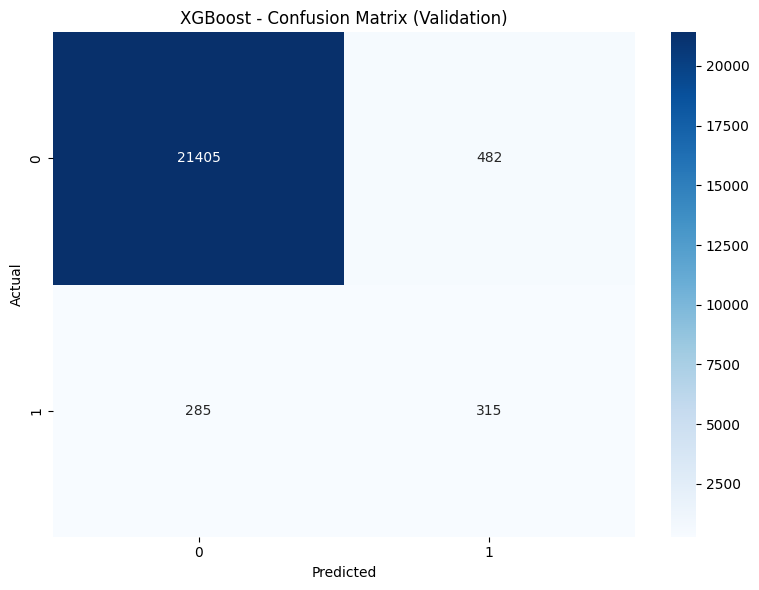

In [16]:
# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val, y_val_pred_xgb)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBoost - Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

### 5.2 LightGBM Baseline

In [17]:
# LightGBM 모델 초기화 (불균형 데이터 처리)
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbose=-1
)

print("LightGBM model initialized")

LightGBM model initialized


In [18]:
# LightGBM 학습
print("Training LightGBM model...")

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss'
)

print("\nLightGBM training completed")

Training LightGBM model...



LightGBM training completed


In [19]:
# LightGBM 예측
y_train_pred_lgb = lgb_model.predict(X_train)
y_val_pred_lgb = lgb_model.predict(X_val)
y_test_pred_lgb = lgb_model.predict(X_test)

y_train_pred_proba_lgb = lgb_model.predict_proba(X_train)[:, 1]
y_val_pred_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]
y_test_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("LightGBM predictions completed")

LightGBM predictions completed


In [20]:
# LightGBM 평가 - Validation
print("="*80)
print("LightGBM - Validation Set Evaluation")
print("="*80)
print(f"\nPrecision: {precision_score(y_val, y_val_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_lgb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred_lgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba_lgb):.4f}")
print(f"PR-AUC: {average_precision_score(y_val, y_val_pred_proba_lgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_lgb))

LightGBM - Validation Set Evaluation

Precision: 0.3596
Recall: 0.5400
F1 Score: 0.4317
ROC-AUC: 0.9156
PR-AUC: 0.4926

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     21887
           1       0.36      0.54      0.43       600

    accuracy                           0.96     22487
   macro avg       0.67      0.76      0.71     22487
weighted avg       0.97      0.96      0.97     22487



In [21]:
# LightGBM 평가 - Test
print("="*80)
print("LightGBM - Test Set Evaluation")
print("="*80)
print(f"\nPrecision: {precision_score(y_test, y_test_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_lgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_lgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_lgb):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_test_pred_proba_lgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lgb))

LightGBM - Test Set Evaluation

Precision: 0.1630
Recall: 0.2175
F1 Score: 0.1864
ROC-AUC: 0.7925
PR-AUC: 0.1556

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     23726
           1       0.16      0.22      0.19       584

    accuracy                           0.95     24310
   macro avg       0.57      0.59      0.58     24310
weighted avg       0.96      0.95      0.96     24310



## 6. Model Comparison

In [22]:
# 모델 비교 테이블
results = {
    'Model': ['XGBoost', 'LightGBM'],
    'Precision (Val)': [
        precision_score(y_val, y_val_pred_xgb),
        precision_score(y_val, y_val_pred_lgb)
    ],
    'Recall (Val)': [
        recall_score(y_val, y_val_pred_xgb),
        recall_score(y_val, y_val_pred_lgb)
    ],
    'F1 (Val)': [
        f1_score(y_val, y_val_pred_xgb),
        f1_score(y_val, y_val_pred_lgb)
    ],
    'ROC-AUC (Val)': [
        roc_auc_score(y_val, y_val_pred_proba_xgb),
        roc_auc_score(y_val, y_val_pred_proba_lgb)
    ],
    'Precision (Test)': [
        precision_score(y_test, y_test_pred_xgb),
        precision_score(y_test, y_test_pred_lgb)
    ],
    'Recall (Test)': [
        recall_score(y_test, y_test_pred_xgb),
        recall_score(y_test, y_test_pred_lgb)
    ],
    'F1 (Test)': [
        f1_score(y_test, y_test_pred_xgb),
        f1_score(y_test, y_test_pred_lgb)
    ],
    'ROC-AUC (Test)': [
        roc_auc_score(y_test, y_test_pred_proba_xgb),
        roc_auc_score(y_test, y_test_pred_proba_lgb)
    ]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
display(results_df.round(4))


Model Comparison:


,Model,Precision (Val),Recall (Val),F1 (Val),ROC-AUC (Val),Precision (Test),Recall (Test),F1 (Test),ROC-AUC (Test)
0,XGBoost,0.3952,0.525,0.4510,0.9085,0.1896,0.2363,0.2104,0.7931
1,LightGBM,0.3596,0.540,0.4317,0.9156,0.1630,0.2175,0.1864,0.7925


## 7. Feature Importance Analysis


XGBoost - Top 20 Important Features:


,feature,importance
0,MCT_OPE_MS_CN,0.031529
67,RC_M1_SAA_ma_12m,0.023889
98,RC_M1_TO_UE_CT_trend_3m,0.023044
101,RC_M1_UE_CUS_CN_trend_3m,0.021950
157,loyalty_trend_12m,0.020118
110,RC_M1_TO_UE_CT_std_3m,0.016918
76,RC_M1_AV_NP_AT_ma_12m,0.016728
108,RC_M1_SAA_std_12m,0.016689
114,RC_M1_TO_UE_CT_std_12m,0.016587
73,RC_M1_UE_CUS_CN_ma_12m,0.016197


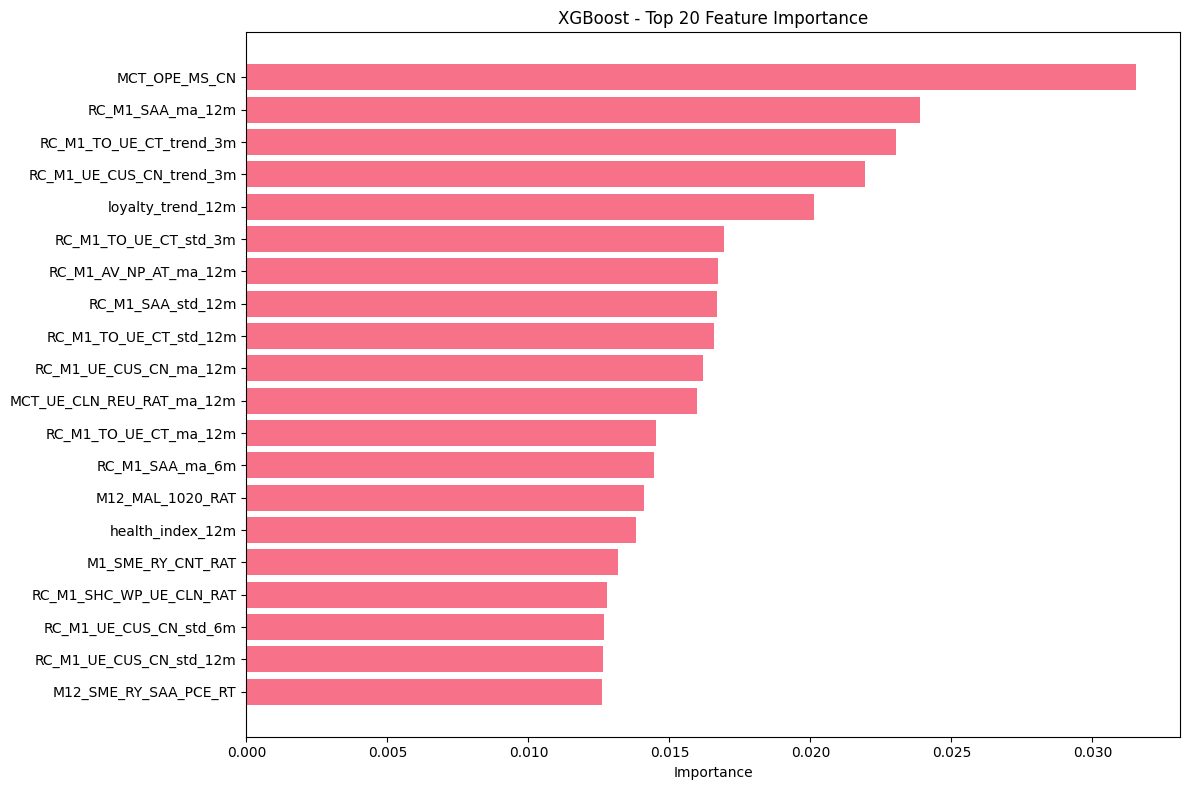

In [23]:
# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nXGBoost - Top 20 Important Features:")
display(xgb_importance.head(20))

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
top_features = xgb_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('XGBoost - Top 20 Feature Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


LightGBM - Top 20 Important Features:


,feature,importance
9,M12_SME_RY_SAA_PCE_RT,181
15,M12_MAL_40_RAT,132
79,MCT_UE_CLN_REU_RAT_ma_12m,132
10,M12_SME_BZN_SAA_PCE_RT,128
13,M12_MAL_1020_RAT,121
20,M12_FME_40_RAT,116
19,M12_FME_30_RAT,110
11,M12_SME_RY_ME_MCT_RAT,109
14,M12_MAL_30_RAT,108
16,M12_MAL_50_RAT,91


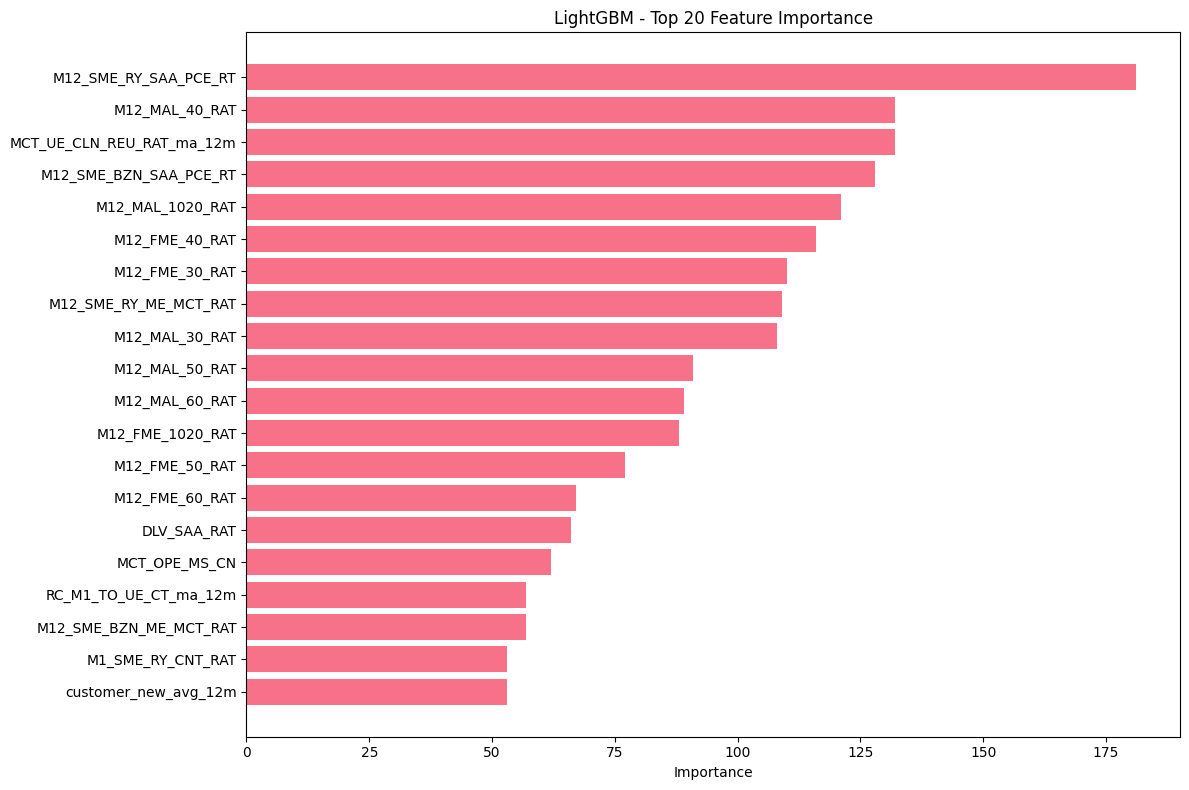

In [24]:
# LightGBM Feature Importance
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nLightGBM - Top 20 Important Features:")
display(lgb_importance.head(20))

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
top_features = lgb_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('LightGBM - Top 20 Feature Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 8. SHAP Value Analysis

SHAP (SHapley Additive exPlanations)를 사용하여 모델의 예측을 해석합니다.

In [25]:
# SHAP explainer 생성 (XGBoost)
print("Creating SHAP explainer for XGBoost...")
explainer_xgb = shap.TreeExplainer(xgb_model)

# SHAP values 계산 (샘플링하여 계산 속도 향상)
sample_size = min(1000, len(X_val))
X_val_sample = X_val.sample(n=sample_size, random_state=42)

print(f"Calculating SHAP values for {sample_size} samples...")
shap_values_xgb = explainer_xgb.shap_values(X_val_sample)

print("SHAP calculation completed")

Creating SHAP explainer for XGBoost...
Calculating SHAP values for 1000 samples...
SHAP calculation completed



SHAP Summary Plot - XGBoost:


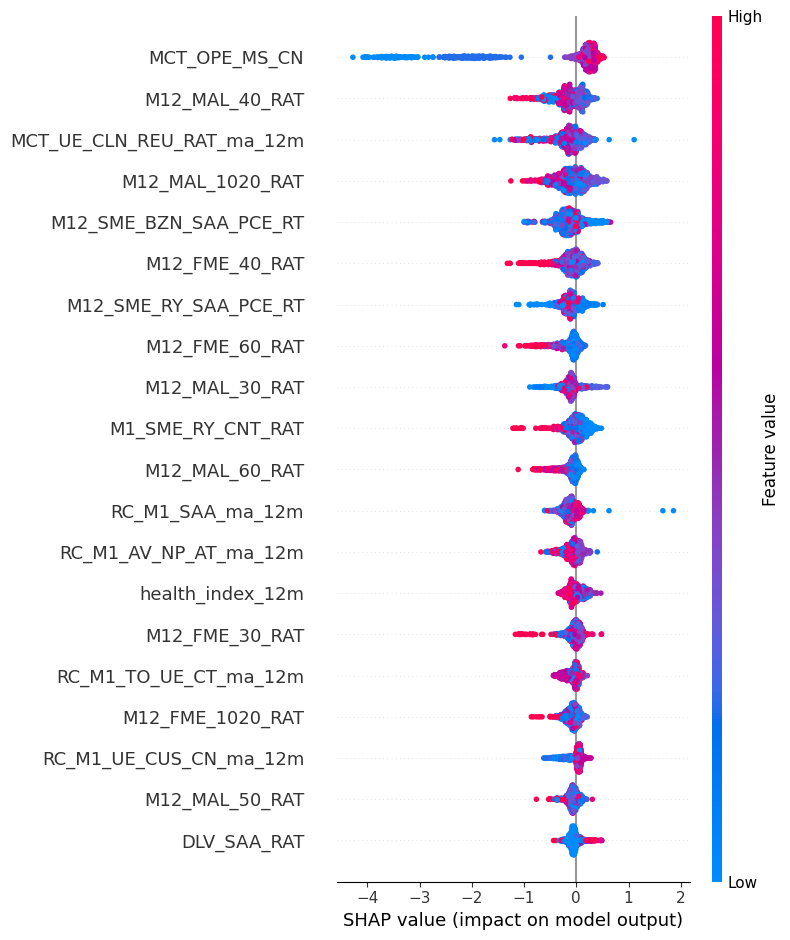

In [26]:
# SHAP Summary Plot (XGBoost)
print("\nSHAP Summary Plot - XGBoost:")
shap.summary_plot(shap_values_xgb, X_val_sample, show=False)
plt.tight_layout()
plt.show()


SHAP Feature Importance (Mean |SHAP value|) - XGBoost:


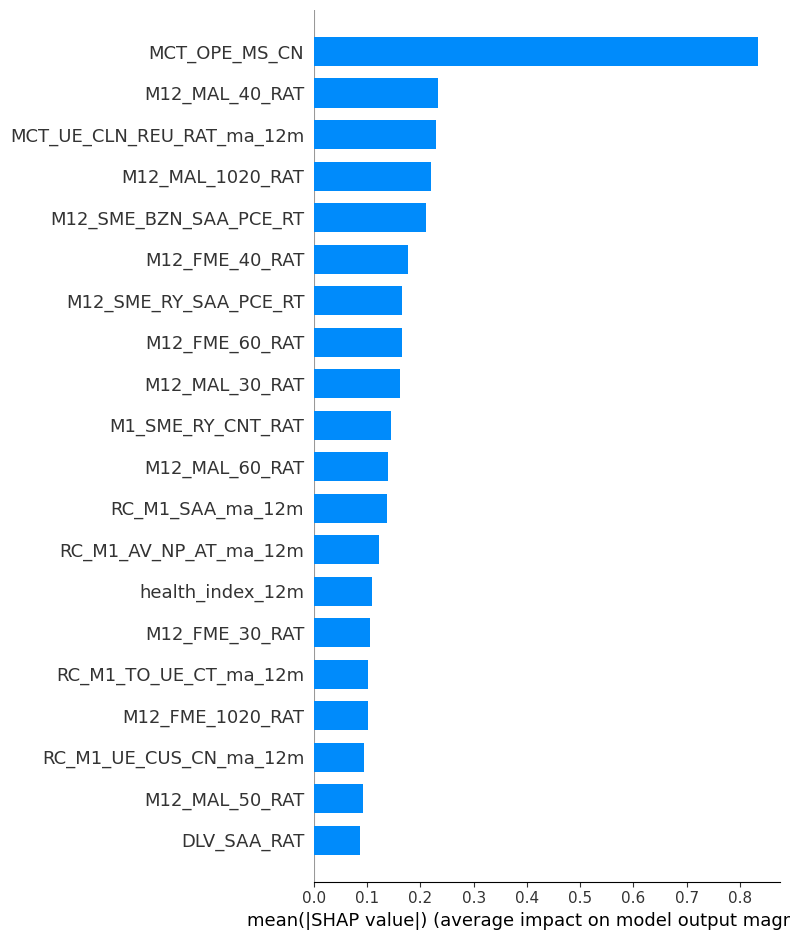

In [27]:
# SHAP Bar Plot - Mean absolute SHAP values
print("\nSHAP Feature Importance (Mean |SHAP value|) - XGBoost:")
shap.summary_plot(shap_values_xgb, X_val_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning

성능이 더 좋은 모델에 대해 Hyperparameter tuning을 수행합니다.

In [28]:
# Grid Search를 위한 파라미터 그리드 정의 (XGBoost)
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Parameter grid for XGBoost:")
print(param_grid_xgb)
print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid_xgb.values()])}")

Parameter grid for XGBoost:
{'max_depth': [4, 6, 8], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [100, 200], 'min_child_weight': [1, 3, 5], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}

Total combinations: 216


In [29]:
# Note: Full grid search would take too long, so we'll use RandomizedSearchCV instead
from sklearn.model_selection import RandomizedSearchCV

print("Starting RandomizedSearchCV for XGBoost...")
print("This may take several minutes...\n")

xgb_random = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    ),
    param_distributions=param_grid_xgb,
    n_iter=20,  # 20 random combinations
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Combine train + val for hyperparameter tuning
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

xgb_random.fit(X_train_val, y_train_val)

print("\nBest parameters:")
print(xgb_random.best_params_)
print(f"\nBest ROC-AUC score: {xgb_random.best_score_:.4f}")

Starting RandomizedSearchCV for XGBoost...
This may take several minutes...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Best ROC-AUC score: 0.8688


In [30]:
# 최적 모델로 Test 세트 평가
best_xgb_model = xgb_random.best_estimator_

y_test_pred_best = best_xgb_model.predict(X_test)
y_test_pred_proba_best = best_xgb_model.predict_proba(X_test)[:, 1]

print("="*80)
print("Tuned XGBoost - Test Set Evaluation")
print("="*80)
print(f"\nPrecision: {precision_score(y_test, y_test_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_best):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_best):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_test_pred_proba_best):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_best))

Tuned XGBoost - Test Set Evaluation

Precision: 0.7517
Recall: 0.3784
F1 Score: 0.5034
ROC-AUC: 0.9260
PR-AUC: 0.5482

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23726
           1       0.75      0.38      0.50       584

    accuracy                           0.98     24310
   macro avg       0.87      0.69      0.75     24310
weighted avg       0.98      0.98      0.98     24310



## 10. 최종 모델 저장

In [31]:
# 모델 저장
import pickle
from pathlib import Path

model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Best XGBoost 모델 저장
with open(model_dir / 'xgboost_best.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)
print(f"Saved: {model_dir / 'xgboost_best.pkl'}")

# LightGBM 모델 저장
with open(model_dir / 'lightgbm_baseline.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)
print(f"Saved: {model_dir / 'lightgbm_baseline.pkl'}")

# Feature 목록 저장
with open(model_dir / 'feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"Saved: {model_dir / 'feature_cols.pkl'}")

Saved: ../models/xgboost_best.pkl
Saved: ../models/lightgbm_baseline.pkl
Saved: ../models/feature_cols.pkl


In [32]:
# 최종 결과 저장
final_results = {
    'model': 'XGBoost (Tuned)',
    'test_precision': precision_score(y_test, y_test_pred_best),
    'test_recall': recall_score(y_test, y_test_pred_best),
    'test_f1': f1_score(y_test, y_test_pred_best),
    'test_roc_auc': roc_auc_score(y_test, y_test_pred_proba_best),
    'test_pr_auc': average_precision_score(y_test, y_test_pred_proba_best),
    'best_params': xgb_random.best_params_,
    'feature_count': len(feature_cols),
    'train_samples': len(X_train_val),
    'test_samples': len(X_test)
}

import json
with open(model_dir / 'final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\nSaved: {model_dir / 'final_results.json'}")


Saved: ../models/final_results.json


## 11. 결론

### 완료된 작업
1. ✅ 데이터 로드 및 전처리
2. ✅ Train/Validation/Test Split (시계열 고려)
3. ✅ XGBoost Baseline 모델
4. ✅ LightGBM Baseline 모델
5. ✅ 모델 비교 및 평가
6. ✅ Feature Importance 분석
7. ✅ SHAP Value 분석
8. ✅ Hyperparameter Tuning
9. ✅ 최종 모델 저장

### 주요 결과
- 불균형 데이터 문제를 `scale_pos_weight`로 해결
- 시계열 특성을 고려한 데이터 분할
- Feature importance와 SHAP을 통한 모델 해석
- Hyperparameter tuning으로 성능 개선

### 다음 단계
- 더 많은 Feature Engineering
- 앙상블 모델 (Stacking, Voting)
- 비즈니스 메트릭 기반 임계값 조정
- 프로덕션 배포 준비

In [33]:
print("\n" + "="*80)
print("MODEL TRAINING COMPLETED")
print("="*80)
print(f"\nBest Model: XGBoost (Tuned)")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_best):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred_best):.4f}")
print(f"\nModels saved to: {model_dir}")


MODEL TRAINING COMPLETED

Best Model: XGBoost (Tuned)
Test ROC-AUC: 0.9260
Test F1 Score: 0.5034

Models saved to: ../models
